In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Database credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))


# Use the connection to extract SQL data
education_df = pd.read_sql_query('SELECT * FROM useducation', con=engine)

# Close the connection
engine.dispose()

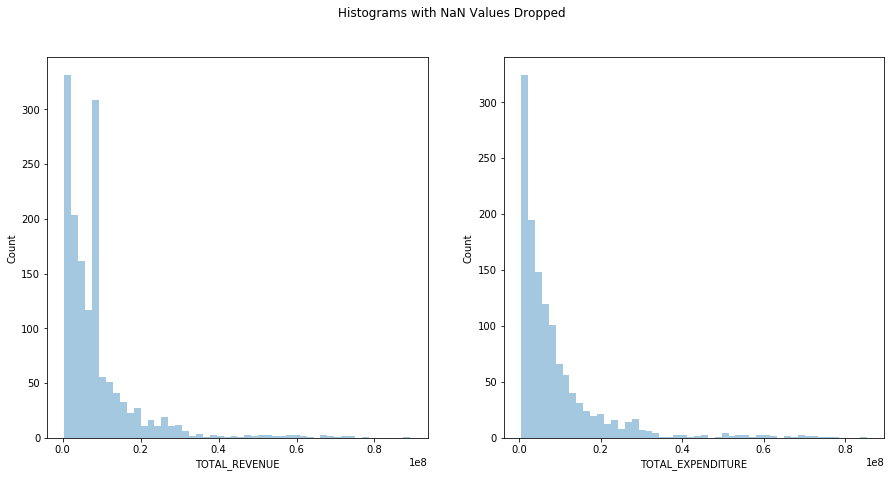

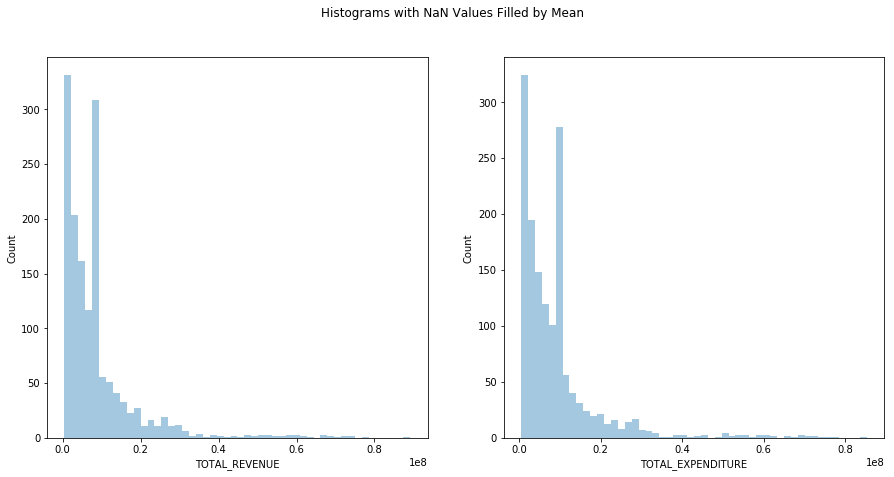

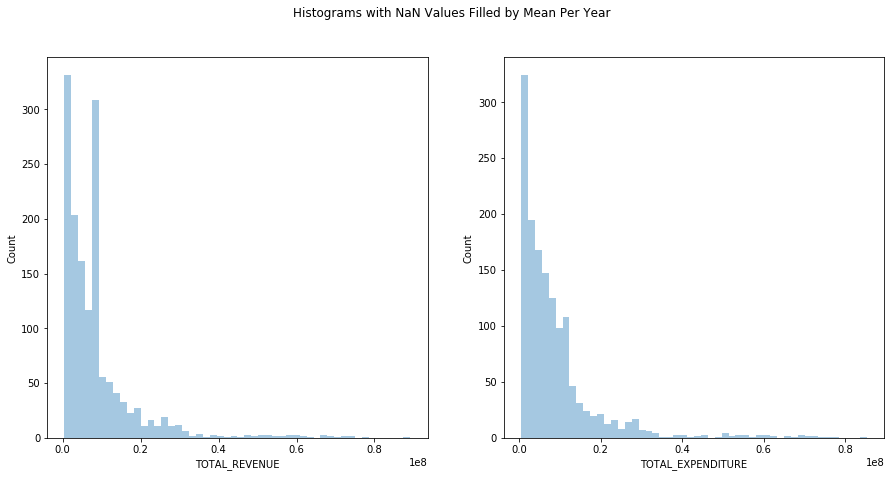

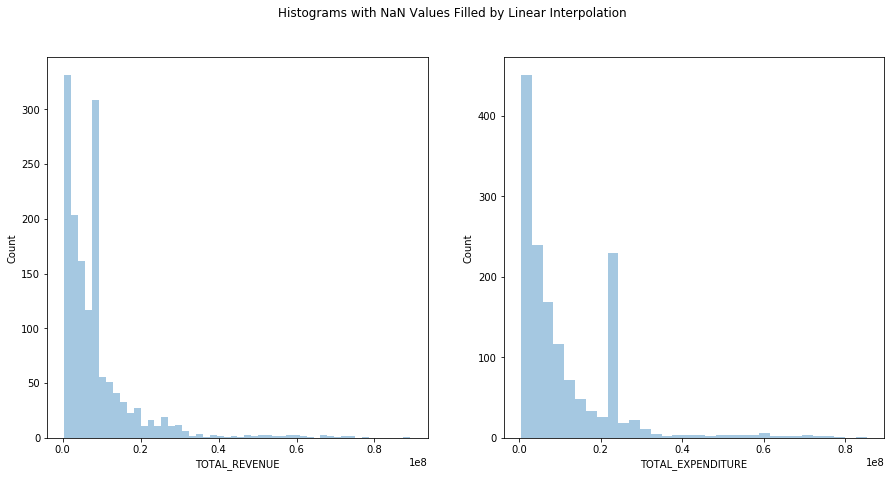

In [23]:
#Initial exploration of columns in question

#NaN values dropped
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.distplot(education_df['TOTAL_REVENUE'].dropna(), kde=False, norm_hist = False)
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.distplot(education_df['TOTAL_EXPENDITURE'].dropna(), kde=False, norm_hist = False)
plt.ylabel('Count')

plt.suptitle('Histograms with NaN Values Dropped')
plt.show()


#NaN Values filled by mean of column
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.distplot(education_df['TOTAL_REVENUE'].fillna(education_df['TOTAL_REVENUE'].mean()), kde=False, norm_hist = False)
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.distplot(education_df['TOTAL_EXPENDITURE'].fillna(education_df['TOTAL_EXPENDITURE'].mean()), kde=False, norm_hist = False)
plt.ylabel('Count')

plt.suptitle('Histograms with NaN Values Filled by Mean')
plt.show()


#NaN Values filled by mean of column, separated by year

#Make a copy of the dataframe to fill the NaNs, drop any that are still unfilled
educationdf_3 = education_df.copy()

#Fill missing values with mean values of the column, accounting for year
unique_years = list(educationdf_3['YEAR'].unique())
for column in list(educationdf_3.columns.drop(['PRIMARY_KEY', 'STATE', 'YEAR'])):
    for year in unique_years:
        educationdf_3[column][educationdf_3['YEAR'] == year] = educationdf_3[column][educationdf_3['YEAR'] == year].replace(np.nan, educationdf_3[column][educationdf_3['YEAR'] == year].mean())
        
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.distplot(educationdf_3['TOTAL_REVENUE'].dropna(), kde=False, norm_hist = False)
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.distplot(educationdf_3['TOTAL_EXPENDITURE'].dropna(), kde=False, norm_hist = False)
plt.ylabel('Count')

plt.suptitle('Histograms with NaN Values Filled by Mean Per Year')
plt.show()



#NaN Values filled by mean of column, separated by year

#Make a copy of the dataframe to fill the NaNs
educationdf_4 = education_df.copy()

#Fill missing values by interpolation
educationdf_4 = educationdf_4.interpolate(method ='linear', limit_direction ='forward') 

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.distplot(educationdf_4['TOTAL_REVENUE'].dropna(), kde=False, norm_hist = False)
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.distplot(educationdf_4['TOTAL_EXPENDITURE'].dropna(), kde=False, norm_hist = False)
plt.ylabel('Count')

plt.suptitle('Histograms with NaN Values Filled by Linear Interpolation')
plt.show()



The means per year version of filling the missing data seems to show the least amount of skew in the final histogram, so that's the missing value technique we'll be using when analyzing the data in this assignment.

### 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?
Based on the histograms shown above, it seems obvious that there are many outlier values, since most of the values are clustered to the left, but the plot still spreads pretty far in the x-direction. However, a boxplot for each variable should show the outliers more clearly.

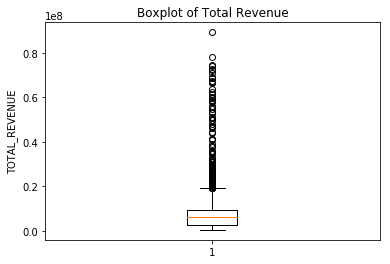

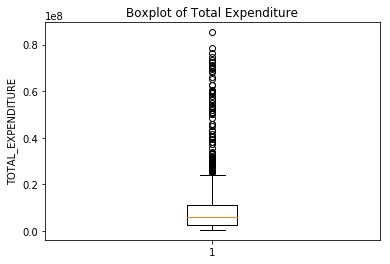

In [28]:
#Boxplot for each variable
plt.boxplot(educationdf_3['TOTAL_REVENUE'])
plt.ylabel('TOTAL_REVENUE')
plt.title('Boxplot of Total Revenue')
plt.show()

plt.boxplot(educationdf_3['TOTAL_EXPENDITURE'].dropna())
plt.ylabel('TOTAL_EXPENDITURE')
plt.title('Boxplot of Total Expenditure')
plt.show()

### 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

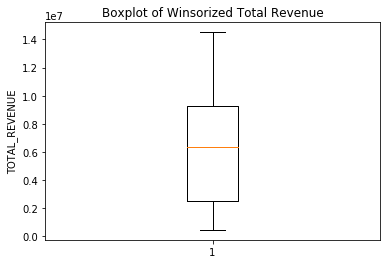

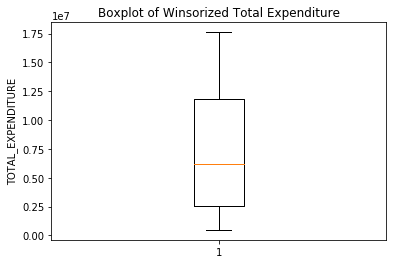

In [38]:
#Limit outlier values using winsorize()

from scipy.stats.mstats import winsorize

winsorized_rev = winsorize(educationdf_3['TOTAL_REVENUE'], (0, 0.15))
winsorized_exp = winsorize(educationdf_3['TOTAL_EXPENDITURE'], (0, 0.15))

plt.boxplot(winsorized_rev)
plt.ylabel('TOTAL_REVENUE')
plt.title('Boxplot of Winsorized Total Revenue')
plt.show()

plt.boxplot(winsorized_exp)
plt.ylabel('TOTAL_EXPENDITURE')
plt.title('Boxplot of Winsorized Total Expenditure')
plt.show()

### 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

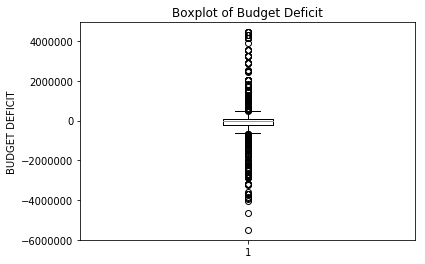

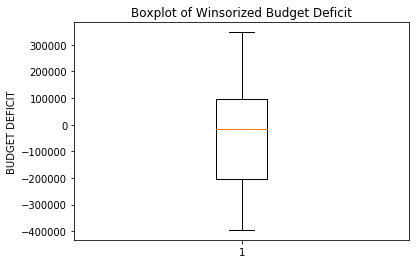

In [51]:
budget_def = educationdf_3['TOTAL_REVENUE'] - educationdf_3['TOTAL_EXPENDITURE']

plt.boxplot(budget_def.dropna())
plt.ylabel('BUDGET DEFICIT')
plt.title('Boxplot of Budget Deficit')
plt.show()



winsorized_def = winsorize(budget_def, (0.15, 0.15))

plt.boxplot(winsorized_def)
plt.ylabel('BUDGET DEFICIT')
plt.title('Boxplot of Winsorized Budget Deficit')
plt.show()

### 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

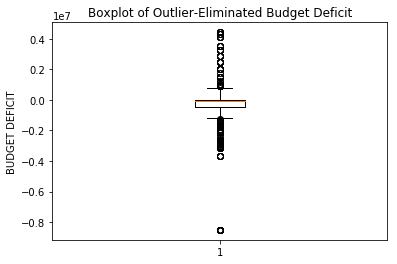

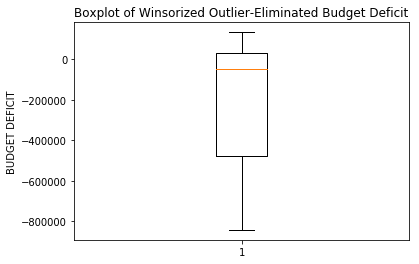

In [57]:
deficit_outlierelim = winsorized_rev - winsorized_exp

plt.boxplot(deficit_outlierelim)
plt.ylabel('BUDGET DEFICIT')
plt.title('Boxplot of Outlier-Eliminated Budget Deficit')
plt.show()


winsorized_outelimdef = winsorize(deficit_outlierelim, (0.22, 0.15))
plt.boxplot(winsorized_outelimdef)
plt.ylabel('BUDGET DEFICIT')
plt.title('Boxplot of Winsorized Outlier-Eliminated Budget Deficit')
plt.show()


### 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

In [67]:
print('Original Budget Deficit - Descriptive Statistics: ')
print(budget_def.describe())
print('\n')


print('Question 3 Budget Deficit - Descriptive Statistics: ')
print(pd.DataFrame(winsorized_def)[0].describe())
print('\n')

print('Question 4 Budget Deficit - Descriptive Statistics: ')
print(pd.DataFrame(winsorized_outelimdef)[0].describe())

Original Budget Deficit - Descriptive Statistics: 
count    1.441000e+03
mean    -9.847543e+04
std      1.009563e+06
min     -5.487742e+06
25%     -2.156200e+05
50%     -2.176600e+04
75%      7.102000e+04
max      4.438491e+06
dtype: float64


Question 3 Budget Deficit - Descriptive Statistics: 
count      1492.000000
mean     -33124.319552
std      236257.945764
min     -395270.000000
25%     -203897.750000
50%      -14721.000000
75%       97906.250000
max      347190.000000
Name: 0, dtype: float64


Question 4 Budget Deficit - Descriptive Statistics: 
count      1492.000000
mean    -225373.312946
std      364362.991677
min     -841773.533563
25%     -477754.500000
50%      -48997.000000
75%       29742.250000
max      133740.000000
Name: 0, dtype: float64


Pretty much all of the descriptive statistics have changed between the two methods of calculating the budget deficit. The means differ by a factor of 10, and the standard deviations differ by a factor of approximately 1/3.

### 6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

The method in the third question provides mean and standard deviation values closest to the actual values of the deficit, so if our variable of interest is the deficit, we should use the 3rd question method. The 4th question's method introduces more inaccuracies.